In [102]:
import numpy as np
np.random.seed(0)
# プロット用の設定
from matplotlib import pyplot as plt
import seaborn as sns
plt.rcParams["font.family"] = "MS Gothic"
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.style.use("ggplot")
from statsmodels.regression.quantile_regression import QuantReg
from scipy.stats import lognorm
from scipy.stats import norm
import pandas as pd
import itertools

In [103]:
# ggplotのパレット
palette_ggplot = {"red": "#df4219", "green": "#04a5a8", "blue": "#01abdb", "orange": "#f37938", \
                  "yellow": "#fec415", "light_grey": "#ccccdd", "dark_grey": "#8d9d8d"}

$n$乗誤差のプロット

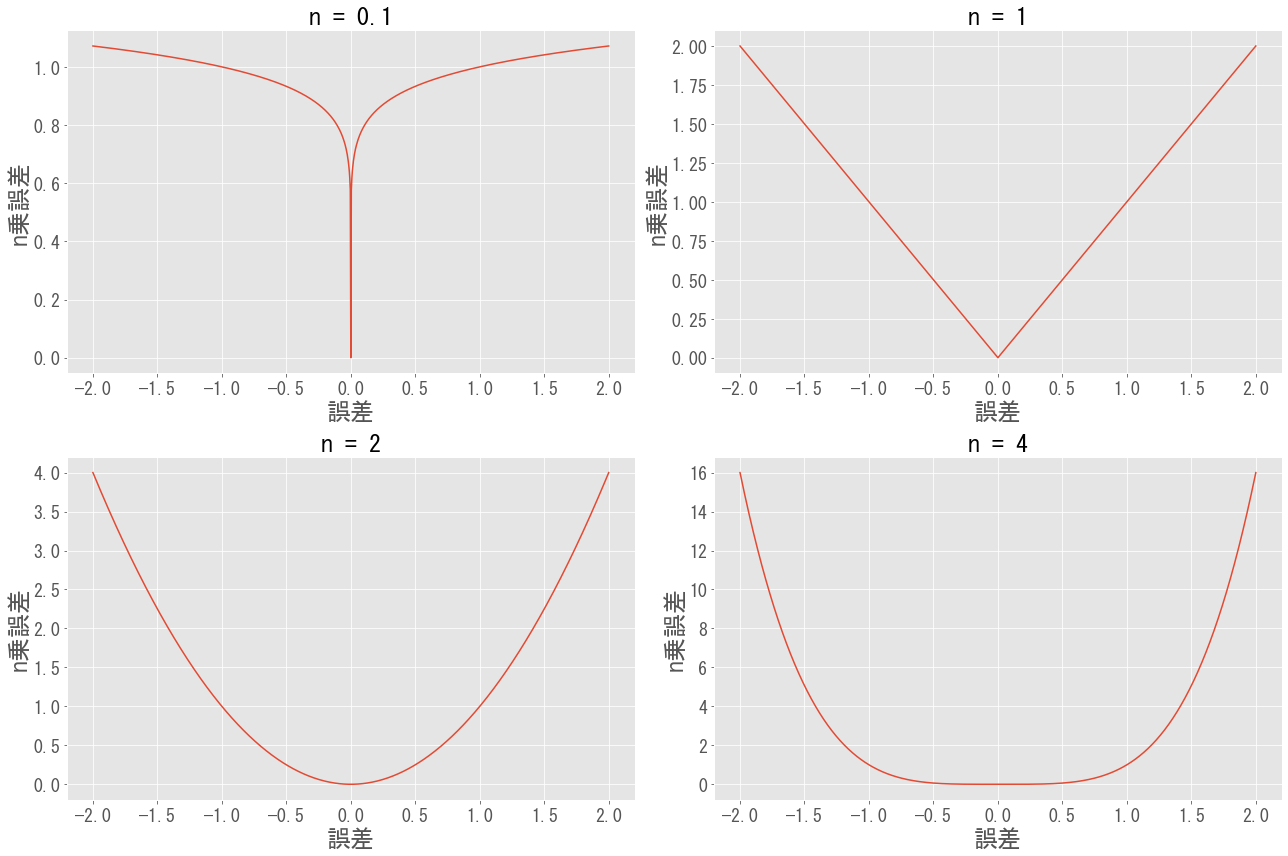

In [104]:
n_list = [0.1, 1, 2, 4] # n乗誤差のリスト
y_list = np.linspace(-2.0, 2.0, 1001) # 誤差の範囲（0を含むように設定）

fig = plt.figure(figsize = (18, 12))

for idx, n in enumerate(n_list):
    ax = fig.add_subplot(2, 2, idx + 1)
    error = np.abs(y_list) ** n
    ax.plot(y_list, error)
    ax.set_title("n = " + str(n), fontsize = 24)
    ax.set_xlabel("誤差", fontsize = 24)
    ax.set_ylabel("n乗誤差", fontsize = 24)
fig.tight_layout()

対数正規分布で最頻値，中央値，期待値を確認

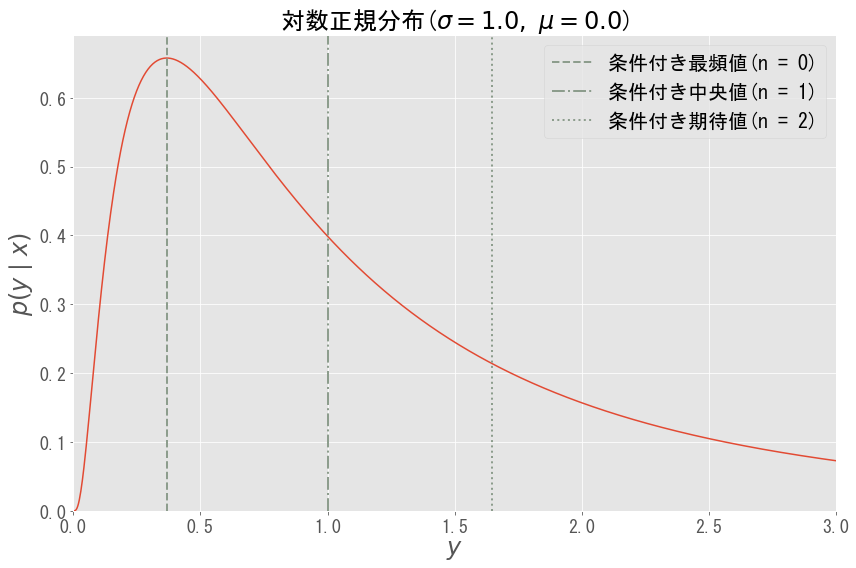

In [105]:
sigma, mu = 1.0, 0.0 # 対数正規分布のパラメータ
y_min, y_max = 0.0001, 3.0 # 0とすると確率密度がうまく計算できない
y_list = np.linspace(y_min, y_max, 1000)
p_density = (1.0 / (np.sqrt(2.0*np.pi)*sigma*y_list)) * np.exp(-0.5 * (np.log(y_list) - mu) ** 2.0 / (sigma ** 2.0)) # 対数正規分布
log_norm_mean = np.exp(mu + 0.5 * sigma ** 2.0) # 期待値
log_norm_median = np.exp(mu) # 中央値
log_norm_mode = np.exp(mu - sigma ** 2.0) # 最頻値
'''
# 四乗誤差の最小化に使えるパラメータ
log_norm_std = np.sqrt(np.exp(2*mu+ sigma ** 2.0) * (np.exp(sigma ** 2.0) - 1.0)) # 標準偏差
alpha = np.sqrt(np.exp(sigma ** 2.0) - 1.0) * (np.exp(sigma ** 2.0) + 2.0) # 歪度
log_norm_4power = log_norm_mean + log_norm_std * \
    ((0.5 * alpha + np.sqrt((alpha ** 2.0) / 4.0 + 1)) ** (1.0/3.0) - (-0.5 * alpha + np.sqrt((alpha ** 2.0) / 4.0 + 1)) ** (1.0/3.0))
'''

fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111)
ax.plot(y_list, p_density)
# 縦線で最頻値，中央値，期待値の位置を表示
ax.axvline(log_norm_mode, label = "条件付き最頻値(n = 0)", color = palette_ggplot["dark_grey"], linestyle = "--", linewidth = 2.0)
ax.axvline(log_norm_median, label = "条件付き中央値(n = 1)", color = palette_ggplot["dark_grey"], linestyle = "-.", linewidth = 2.0)
ax.axvline(log_norm_mean, label = "条件付き期待値(n = 2)", color = palette_ggplot["dark_grey"], linestyle = ":", linewidth = 2.0)

ax.set_title("対数正規分布($\sigma = 1.0,~ \mu = 0.0$)", fontsize = 24)
ax.set_xlabel("$y$", fontsize = 24)
ax.set_ylabel("$p(y \mid x)$", fontsize = 24)

ax.set_xlim(0.0, y_max)
ax.set_ylim(0.0, None)
ax.legend(fontsize = 20)
fig.tight_layout()

データを生成．$x$と$y$はいずれも対数正規分布から抽出．線形回帰によって最頻値，中央値，期待値を表現できるよう，ややテクニカルな分布を設定．

$$
p(x) = \dfrac{1}{\sqrt{2 \pi \sigma_x^2 } x} \exp \left[ - \dfrac{(\log x - \mu_x)^2}{2 \sigma_x^2}\right] \\
p(y \mid x) = \dfrac{1}{\sqrt{2 \pi \sigma_y^2 } y} \exp \left[ - \dfrac{(\log y - \log x)^2}{2 \sigma_y^2}\right] \\
$$

In [106]:
N = 10000
# 入力xの分布
mu_x, sigma_x = 0.0, 0.5 # いずれも定数
x_list = lognorm(s = sigma_x, scale = np.exp(mu_x)).rvs(size = N)
# 出力yの分布
mu_y_list = np.log(x_list)
simga_y = 1.0 # 分散は定数
sigma_y_list = simga_y * np.ones(N)
y_list = lognorm(s = sigma_y_list, scale = np.exp(mu_y_list)).rvs()

# プロット用のx，yの値
x_lin_list = np.linspace(min(x_list), max(x_list), N)
X = np.ones((N, 2)) # 定数項を加えた行列
X[:, 1] = x_list
X_pred = np.ones((N, 2))
X_pred[:, 1] = x_lin_list

mu_y_lin_list = np.log(x_lin_list)
sigma_y_lin_list = simga_y * np.ones(N)
# プロット用の最頻値，中央値，期待値
log_norm_mean = np.exp(mu_y_lin_list + 0.5 * sigma_y_lin_list ** 2.0)
log_norm_median = np.exp(mu_y_lin_list)
log_norm_mode = np.exp(mu_y_lin_list - sigma_y_lin_list ** 2.0)

In [107]:
# 最小n乗法をもとに線形回帰の重みを最適化する
def GeneralRegGradientDescent(X, y, init_theta, q, lr = 1e-7, num_iters = 20000):
    theta = init_theta
    for i in range(num_iters):
        y_hat = X @ theta # predictions
        delta = y - y_hat  # error
        grad = q * (np.abs(delta) ** (q - 2.0)) * delta
        theta += lr * grad @ X # Update
    return theta

n_list = np.array([0.5, 1.0, 2.0, 4.0]) # これらのnに対して実行（nが0に近いとうまく動かない）
y_pred_list = np.zeros((len(n_list), N)) # プロット用にデータを保存

for idx_n, n in enumerate(n_list):
    init_theta = np.zeros(2) # 重みパラメータの初期値
    theta = GeneralRegGradientDescent(X, y_list, init_theta, q = n)
    print(idx_n, n, theta)
    y_pred_list[idx_n] = X_pred @ theta # プロット用データに対して予測

0 0.5 [0.11467926 0.66645598]
1 1.0 [0.0758304  0.92861224]
2 2.0 [0.05473496 1.61187121]
3 4.0 [1.19047081 3.50927477]


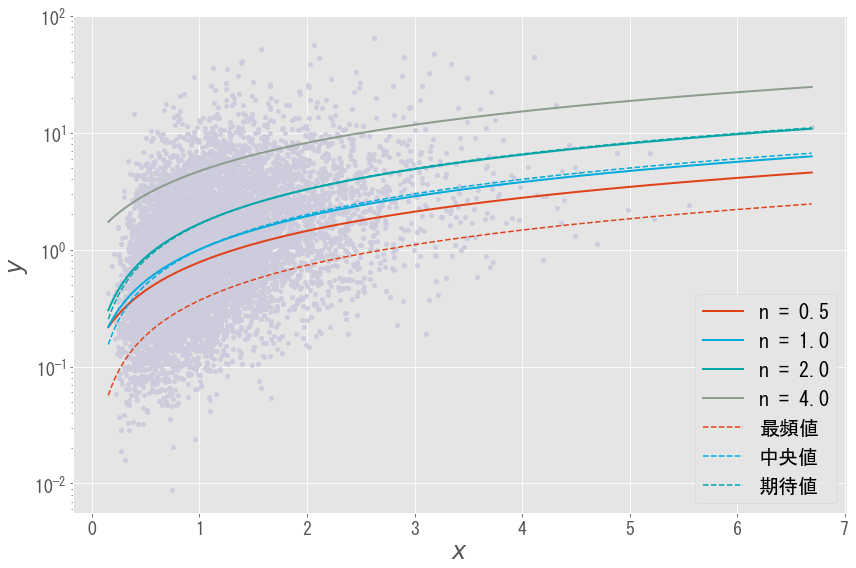

In [108]:
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111)
ax.scatter(x_list, y_list, color = palette_ggplot["light_grey"], s = 20) # データをプロット

color_list = ["red", "blue", "green", "dark_grey"] # 色を指定
label_list = ["最頻値", "中央値", "期待値"]
stats_list = [log_norm_mode, log_norm_median, log_norm_mean]

for idx_n, n in enumerate(n_list):
    # 予測値をプロット
    ax.plot(x_lin_list, y_pred_list[idx_n], linewidth = 2, color = palette_ggplot[color_list[idx_n]], label = "n = "+str(n_list[idx_n]))  # regression line

ax.plot(x_lin_list, log_norm_mode, label = "最頻値", linestyle = "--", color = palette_ggplot[color_list[0]])
ax.plot(x_lin_list, log_norm_median, label = "中央値", linestyle = "--", color = palette_ggplot[color_list[1]])
ax.plot(x_lin_list, log_norm_mean, label = "期待値", linestyle = "--", color = palette_ggplot[color_list[2]])

ax.set_xlabel("$x$", fontsize = 24)
ax.set_ylabel("$y$", fontsize = 24)
# plt.xscale("log")
ax.set_yscale("log") # 対数スケールで表示しないと分かりづらい
ax.legend(fontsize = 20)
fig.tight_layout()

パラメータをグリッドサーチ

In [109]:
w0_min, w0_max, num_grid_w0 = -0.5, 0.5, 200 # 定数項
w1_min, w1_max, num_grid_w1 = -0.2, 1.5, 200 # 係数
w0_list = np.linspace(w0_min, w0_max, num_grid_w0)
w1_list = np.linspace(w1_min, w1_max, num_grid_w1)
df_grid_search = pd.DataFrame(columns = ["w0", "w1", "error"], index = np.arange(len(w0_list) * len(w1_list)))
df_grid_search = df_grid_search.astype("float64")
n_min = 0.01 # より小さいnに対して最適化を試みる

for idx, (w0, w1) in enumerate(itertools.product(w0_list, w1_list)):
    # print(idx, w0, w1)
    theta = np.array([w0, w1])
    y_pred = X @ theta
    log_error = (np.abs(y_list - y_pred) ** n_min).mean()
    df_grid_search.loc[idx] = [w0, w1, log_error]

theta_n_min = df_grid_search.sort_values(by = "error").get(["w0", "w1"]).head(1).values[0] # 最小誤差を与えるパラメータ
print("estimate:", theta_n_min)
print("target:", np.exp(- 0.5 * simga_y ** 2.0)) # 最頻値を与える係数と比較

estimate: [-0.01758794  0.6201005 ]
target: 0.6065306597126334


最適化がどの程度うまくいっているかを確認する．データ数をかなり増やしても最適点の周りがフラットになっているため，最適化がうまく進まないことがわかる．

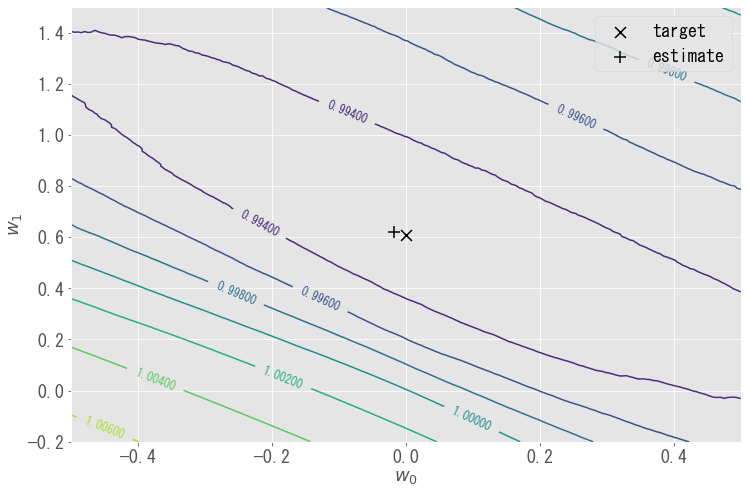

In [110]:
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111)
# 等高線を引くためのいつもの変形
w0_mesh_grid = np.tile(w0_list, (len(w1_list), 1))
w1_mesh_grid = np.tile(w1_list, (len(w0_list), 1)).T
error_mesh_grid = df_grid_search.pivot(values = "error", columns = "w0", index = "w1").values # 少しテクニカル
ax.scatter([0.0], [np.exp(- 0.5 * simga_y ** 2.0)], marker = "x", s = 120, c = "black", label = "target") # 最頻値を与えるパラメータ
ax.scatter(theta_n_min[0], theta_n_min[1], marker = "+", s = 160, c = "black", label = "estimate") # 最小誤差を与えるパラメータ
contour = ax.contour(w0_mesh_grid, w1_mesh_grid, error_mesh_grid)
contour.clabel(fmt = "%1.5f", fontsize = 12)
ax.set_xlabel("$w_0$", fontsize = 18)
ax.set_ylabel("$w_1$", fontsize = 18)
ax.legend(fontsize = 18)

$0 < n < 1$は勾配法ではなくグリッドサーチの結果を使う

In [111]:
n_list = np.array([n_min, 1.0, 2.0, 4.0]) # これらのnに対して実行（n_minに変更）
y_pred_list = np.zeros((len(n_list), N)) # プロット用にデータを保存

for idx_n, n in enumerate(n_list):
    init_theta = np.zeros(2) # 重みパラメータの初期値
    if n == n_min:
        theta = theta_n_min
    else:
        theta = GeneralRegGradientDescent(X, y_list, init_theta, q = n)
    y_pred_list[idx_n] = X_pred @ theta # プロット用データに対して予測

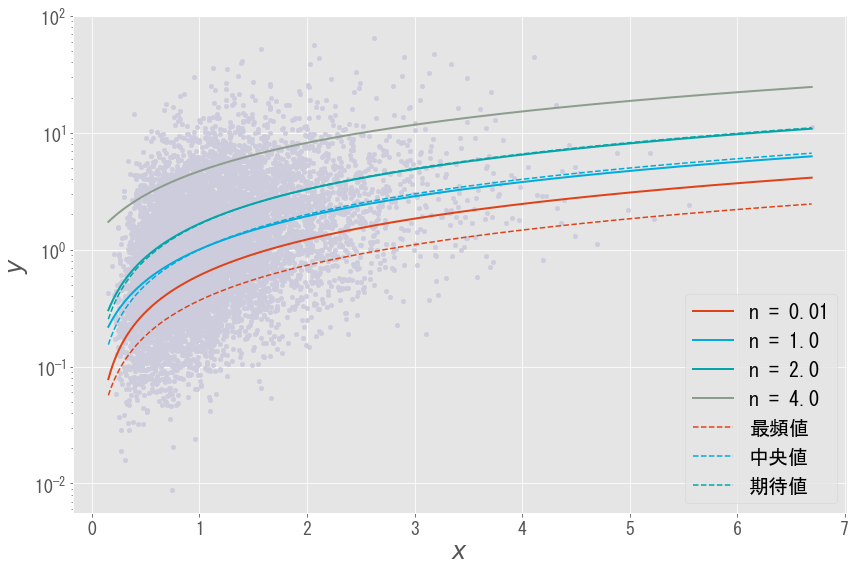

In [112]:
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111)
ax.scatter(x_list, y_list, color = palette_ggplot["light_grey"], s = 20) # データをプロット

color_list = ["red", "blue", "green", "dark_grey"] # 色を指定
label_list = ["最頻値", "中央値", "期待値"]
stats_list = [log_norm_mode, log_norm_median, log_norm_mean]

for idx_n, n in enumerate(n_list):
    # 予測値をプロット
    ax.plot(x_lin_list, y_pred_list[idx_n], linewidth = 2, color = palette_ggplot[color_list[idx_n]], label = "n = "+str(n_list[idx_n]))  # regression line

ax.plot(x_lin_list, log_norm_mode, label = "最頻値", linestyle = "--", color = palette_ggplot[color_list[0]])
ax.plot(x_lin_list, log_norm_median, label = "中央値", linestyle = "--", color = palette_ggplot[color_list[1]])
ax.plot(x_lin_list, log_norm_mean, label = "期待値", linestyle = "--", color = palette_ggplot[color_list[2]])

ax.set_xlabel("$x$", fontsize = 24)
ax.set_ylabel("$y$", fontsize = 24)
# plt.xscale("log")
ax.set_yscale("log") # 対数スケールで表示しないと分かりづらい
ax.legend(fontsize = 20)
fig.tight_layout()

# 最小0乗法の確認

損失関数を$\psi = |x - \hat{x}|^q$とする

prediction: [1.         0.78878879 0.65765766 0.64964965 0.5965966 ]
median: 0.36787944117144233


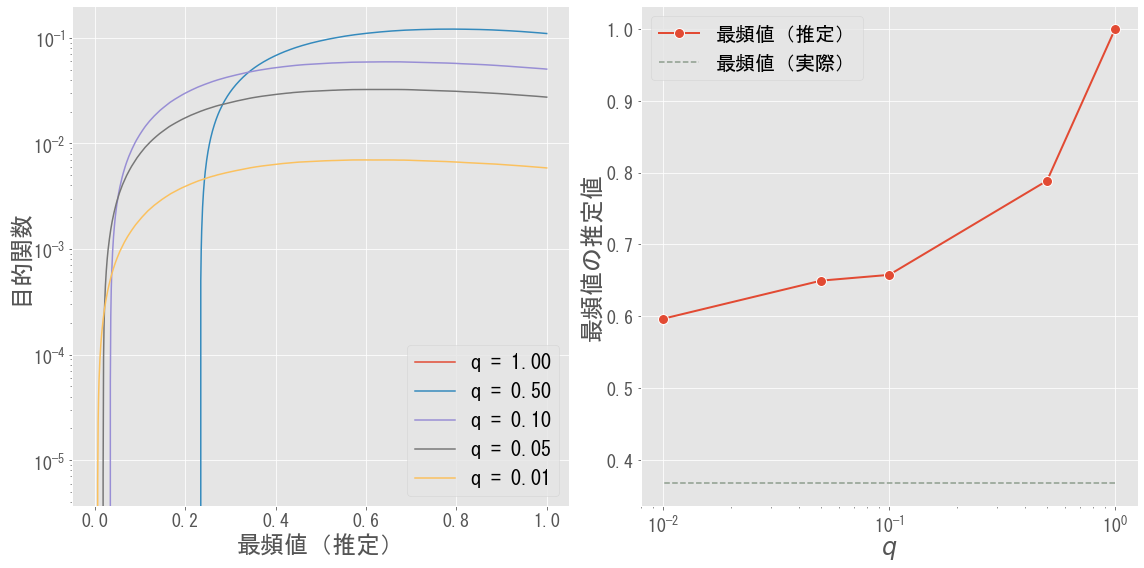

In [113]:
fig = plt.figure(figsize = (16, 8))
ax = fig.add_subplot(1, 2, 1)

N = 100000
sigma, mu = 1.0, 0.0 # 対数正規分布のパラメータ
median_true = np.exp(mu - sigma ** 2.0)

x = lognorm(s = sigma, scale = np.exp(mu)).rvs(size = N)
median_min, median_max, num_grid = 0.0, 1.0, 1000
median_list = np.linspace(median_min, median_max, num_grid)
X = np.subtract.outer(x, median_list)
q_list = [1.0, 0.5, 0.1, 0.05, 0.01]
median_pred_list = np.zeros(len(q_list))

for idx, q in enumerate(q_list):
    error_list = (np.abs(X) ** q).mean(axis = 0)
    ax.plot(median_list, 1 - error_list, label = "q = {:.2f}".format(q))
    median_pred_list[idx] = median_list[np.argmin(error_list)]

ax.set_yscale("log")
ax.legend(fontsize = 18)
ax.set_xlabel("最頻値（推定）", fontsize = 24)
ax.set_ylabel("目的関数", fontsize = 24)
ax.legend(fontsize = 20)

ax = fig.add_subplot(1, 2, 2)
ax.plot(q_list, median_pred_list, linewidth = 2.0, marker = ".", markersize = 20, markeredgecolor = "white", label = "最頻値（推定）")
ax.plot(q_list, median_true * np.ones(len(q_list)), color = palette_ggplot["dark_grey"], linestyle = "--", label = "最頻値（実際）")
ax.set_xlabel("$q$", fontsize = 24)
ax.set_ylabel("最頻値の推定値", fontsize = 24)
ax.set_xscale("log")
ax.legend(fontsize = 20)
fig.tight_layout()

print("prediction:", median_pred_list)
print("median:", median_true)

損失関数を$\psi = \mathbb{I}(|x - \hat{x}| > c)$とする

prediction: [0.36936937 0.42642643 0.47647648 0.55455455 0.61861862 0.7007007 ]
median: 0.36787944117144233


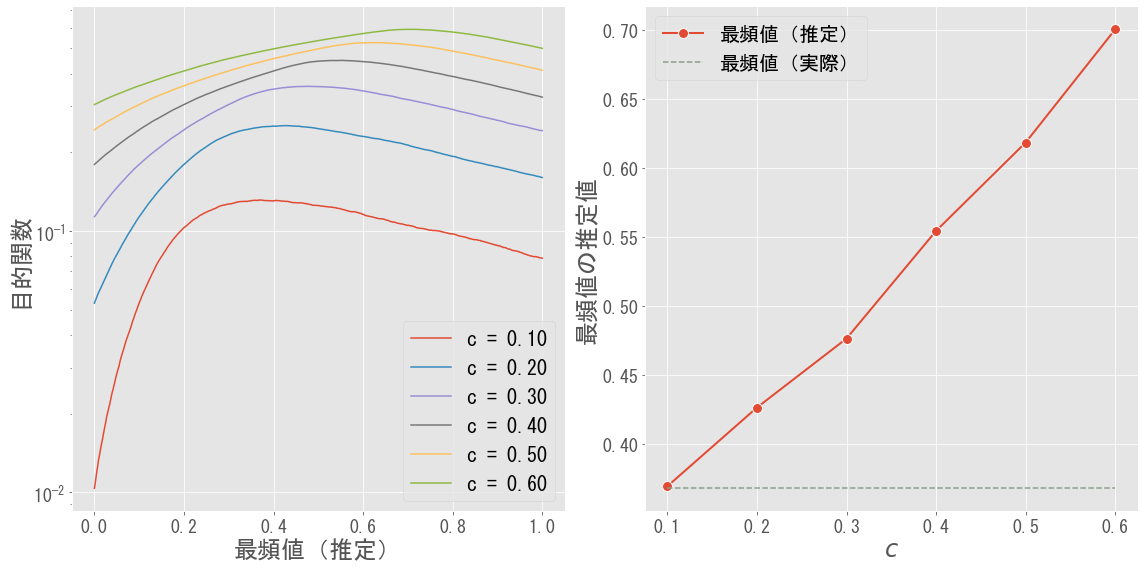

In [114]:
fig = plt.figure(figsize = (16, 8))
ax = fig.add_subplot(1, 2, 1)

N = 100000
sigma, mu = 1.0, 0.0 # 対数正規分布のパラメータ
median_true = np.exp(mu - sigma ** 2.0)

x = lognorm(s = sigma, scale = np.exp(mu)).rvs(size = N)
median_min, median_max, num_grid = 0.0, 1.0, 1000
median_list = np.linspace(median_min, median_max, num_grid)
X = np.subtract.outer(x, median_list)
c_list = np.linspace(0.1, 0.6, 6)
median_pred_list = np.zeros(len(c_list))

for idx, c in enumerate(c_list):
    error_list = (np.abs(X) > c).mean(axis = 0)
    ax.plot(median_list, 1 - error_list, label = "c = {:.2f}".format(c))
    median_pred_list[idx] = median_list[np.argmin(error_list)]

ax.set_yscale("log")
ax.legend(fontsize = 18)
ax.set_xlabel("最頻値（推定）", fontsize = 24)
ax.set_ylabel("目的関数", fontsize = 24)
ax.legend(fontsize = 20)

ax = fig.add_subplot(1, 2, 2)
ax.plot(c_list, median_pred_list, linewidth = 2.0, marker = ".", markersize = 20, markeredgecolor = "white", label = "最頻値（推定）")
ax.plot(c_list, median_true * np.ones(len(c_list)), color = palette_ggplot["dark_grey"], linestyle = "--", label = "最頻値（実際）")
ax.set_xlabel("$c$", fontsize = 24)
ax.set_ylabel("最頻値の推定値", fontsize = 24)
ax.legend(fontsize = 20)
fig.tight_layout()

print("prediction:", median_pred_list)
print("median:", median_true)

混合ガウス分布の推定

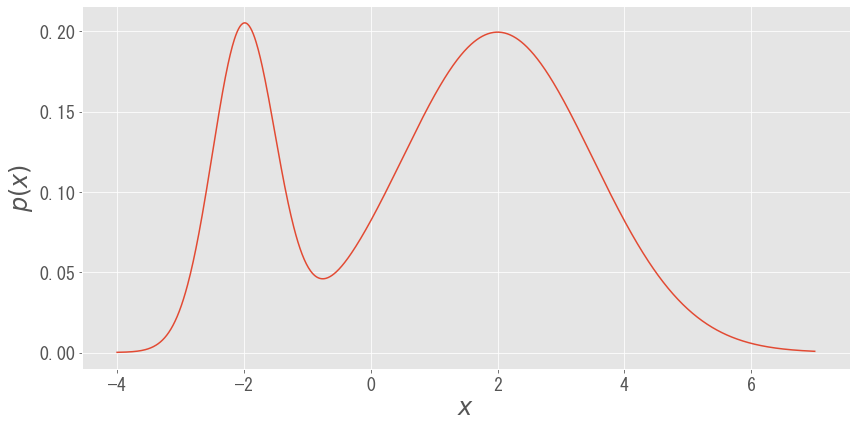

In [115]:
x_list = np.linspace(-4.0, 7.0, 1000)
mu_list, sigma_list, w_list = [2.0, -2.0], [1.5, 0.5], [0.75, 0.25]
f_list = norm.pdf(x_list, loc = mu_list[0], scale = sigma_list[0])
g_list = norm.pdf(x_list, loc = mu_list[1], scale = sigma_list[1])
h_list = w_list[0] * f_list + w_list[1] * g_list
fig = plt.figure(figsize = (12, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(x_list, h_list)
ax.set_xlabel("$x$", fontsize = 24)
ax.set_ylabel("$p(x)$", fontsize = 24)
fig.tight_layout()

In [116]:
N = 1000 # 論文：C. HEINRICH(2013)と合わせるには，10000のデータ点が必要（時間かかるので減らしている）
num_run = 1000
c_list = [0.5, 0.25, 0.1, 0.05, 0.025, 0.001]
median_min, median_max, num_grid = -4.0, 6.0, 500 # (6.0 + 4.0) / 500 = 0.02の精度で推計
median_list = np.linspace(median_min, median_max, num_grid)
df_result = pd.DataFrame(index = np.arange(num_run * len(c_list)), columns = ["c", "idx_run", "median_pred"])

index = 0
for idx_c, c in enumerate(c_list):
    for idx_run in range(num_run):
        indices = np.random.choice(len(mu_list), N, p = w_list)
        mu_list_N = np.take(mu_list, indices) # np.take便利
        sigma_list_N = np.take(sigma_list, indices)
        x = norm.rvs(loc = mu_list_N, scale = sigma_list_N)
        X = np.subtract.outer(x, median_list)
        error_list = (np.abs(X) > c).mean(axis = 0)
        df_result.loc[index] = [c, idx_run, median_list[np.argmin(error_list)]]
        index += 1

df_result["median_pred"] = df_result["median_pred"].astype("float")

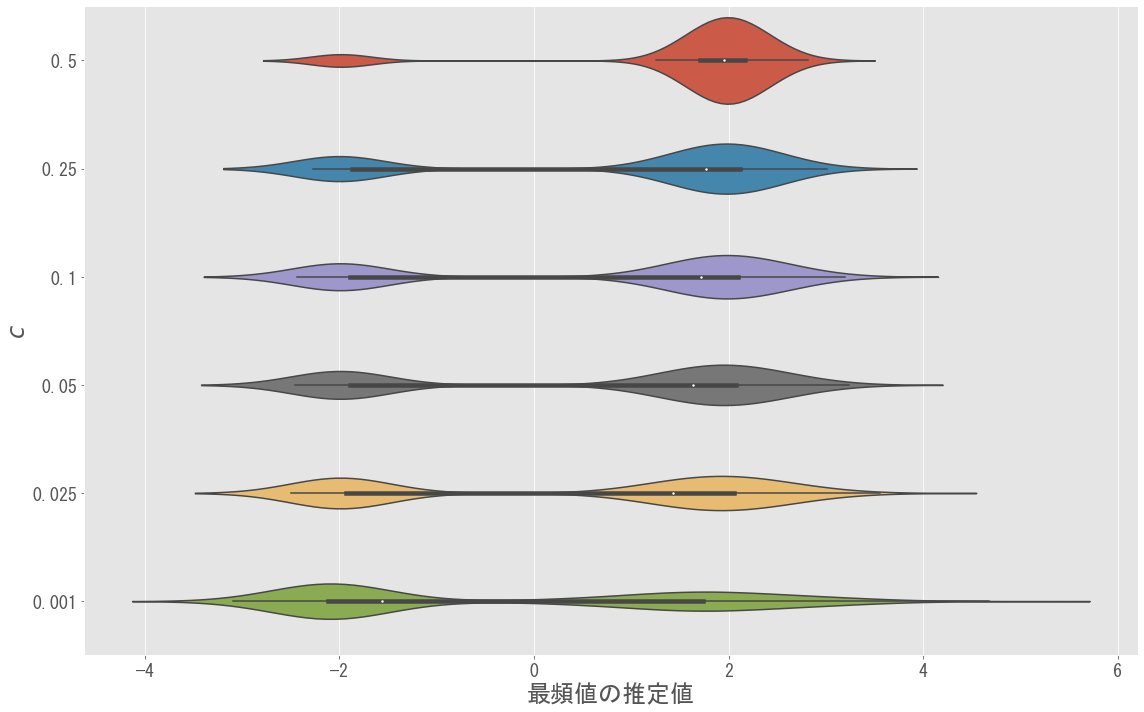

In [127]:
fig = plt.figure(figsize = (16, 10))
ax = fig.add_subplot(1, 1, 1)
sns.violinplot(x = "median_pred", y = "c", data = df_result, orient = "h", order = c_list)
ax.set_xlabel("最頻値の推定値", fontsize = 24)
ax.set_ylabel("$c$", fontsize = 24)
fig.tight_layout()